<h1 align="center">Solving the N-Queens Problem with Evolutionary Algorithms</h1>

In this project, we apply an unconventional approach to find a single solution to the generalized version of the [Eight-queens puzzle](https://en.wikipedia.org/wiki/Eight_queens_puzzle) - the _n-queens puzzle_. That is, placing $n$ queens on an $n \times n$ chessboard such that no two queens are threatening each other. This problem has been previously solved using [backtracking depth-first searches](https://en.wikipedia.org/wiki/Depth-first_search) or efficient analytically-derived algorithms. The results of this notebook show it is possible to find a single solution to the n-queens problem for moderate values of $n$ (up to $n = 64$, a $10^{90}$ search space) by using evolutionary algorithms and genetic programming.

These results are two-fold:
- Whereas optimized backtracking depth-first searches becomes computationally intractable, evolutionary algorithms still have a high probability of finding a valid solution within a reasonable amount of time.
- Specialized knowledge or deep analysis of the problem, although preferred for higher efficiency, was not necessary in finding a valid solution to the problem for moderate values of $n$.

We experiment with two different numerical encodings for chessboard representations and their implications about the search space and the rate of convergence for finding a solution:
- **position indexed queen positions** (search space: $O(n^{2n})$): an $n$-element array where each queen's position $p$ ranges $p\in[0, n^2)$, derived from $p = n \times row + column $.
- **row indexed queen positions** (search space: $O(n^n)$): an $n$-element array where each queen's index indicates its row and its value indicates the column.

> Note: It is possible to reduce the search spaces using encoding representations without duplicate queens, with the new bounds of $O({{n^2} \choose n})$ and $O(n!)$ respectively. However, this requires significantly more programming and reduces the performance of the evolutionary algorithm's fitness evaluation function.

<hr style="border-top: 2px solid #444">

## Development Environment
In this section, the development environment for this Jupyter notebook project is prepared by collecting Python dependencies, importing libraries, and configuring the runtime environment.

### Python Dependencies
External Python dependencies are collected through the [Pipenv](https://pypi.org/project/pipenv/) package manager since it supports dependency lock-files. In the following script, `pipenv` and its transitive dependencies are installed from `pipenv-requirements.txt` and then the notebook's dependencies are installed from `Pipfile` and `Pipfile.lock`.

In [1]:
!pip install -r pipenv-requirements.txt
!pipenv install

### Library Imports
All internal standard libraries and external libraries are imported here, with some dependency versions.

In [2]:
import math
import random
import sys
from time import time
from typing import List, Tuple, Callable, TypeVar

import deap
import matplotlib.pyplot as pyplot
import numpy
import pandas
from IPython.display import display
from deap import algorithms, base, creator, tools

print(f"Python version: {sys.version}")
print(f"DEAP version: {deap.__version__}")
print(f"Numpy version: {numpy.__version__}")

Python version: 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]
DEAP version: 1.3
Numpy version: 1.19.2


### Configure PRNG Seed
DEAP relies on Python's default pseudorandom number generator (PRNG) for its internal computations, located within the `random` module. To guarantee deterministic behaviour and reproducible results during this notebook's execution, an arbitrary seed is configured.

In [3]:
random.seed(43)

### Configure Pandas Table Truncation
Pandas is used to render HTML chessboards using dataframes. By default, Pandas truncates rendered dataframes; this is disabled so that the full chessboard is rendered without any truncated rows or columns.

In [4]:
pandas.set_option('display.max_rows', None)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.width', None)
pandas.set_option('display.max_colwidth', None)

<hr style="border-top: 2px solid #444">

## I. DEAP Toolkit
In this section, a few DEAP utility functions are defined for re-use throughout the notebook. Most of the heavy lifting and core functionality is implemented here for running an evolutionary algorithms simulation.

### Evolutionary Algorithm Function
The following method simulates selection in a randomly created population with DEAP's simple evolutionary algorithm; the configured genetic operators are two-point [crossovers](https://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)) and a parameterized [mutation](https://en.wikipedia.org/wiki/Mutation_(genetic_algorithm)) function (typically, a uniform int range). The fitness evaluation function used throughout the notebook is a count of the number of distinct queen pairs that are threatening each other; thus, the problem is to minimize the fitness of individuals.

Several parameters for the evolutionary algorithm simulation are parameterized for re-use:
- `individual_generator`: a function to generate a genetic encoding for an individual
- `fitness_evaluation`: a fitness evaluation function for an individual's genetic encoding
- `population_size`: the population size to generate for the simulation
- `generations`: the number of generations to run the simulation
- `crossover_rate`: the probability of applying a two-point crossover to generate a new individual
- `mutation_rate`: the probability of applying the mutation function to generate a new individual
- `mutation_function` the mutation function for creating new mutated individuals

In [5]:
# minimize fitness
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

T = TypeVar('T')
def evolution(*,
      individual_generator: Callable[[], T],
      fitness_evaluation: Callable[[T], float],
      population_size: int,
      generations: int,
      crossover_rate: float,
      mutation_rate: float,
      mutation_function: Tuple[Callable, dict],
):
    # track start time
    start_time = time()

    toolbox = base.Toolbox()

    # register population generators
    toolbox.register("individual", tools.initIterate, creator.Individual, individual_generator)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # register fitness evaluation function
    toolbox.register("evaluate", lambda individual: (fitness_evaluation(individual),))

    # register mutators for individuals
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", mutation_function[0], **mutation_function[1])

    # register next generation selection function
    toolbox.register("select", tools.selTournament, tournsize=4)

    # generation statistics logging
    stats = tools.Statistics(key=lambda individual: individual.fitness.values)
    stats.register("min", lambda population: numpy.min([fitness for fitness in population if fitness[0] != math.inf]))
    stats.register("avg", lambda population: numpy.mean([fitness for fitness in population if fitness[0] != math.inf]))
    stats.register("max", lambda population: numpy.max([fitness for fitness in population if fitness[0] != math.inf]))

    # log fittest individual with a hall of fame record
    hall_of_fame = tools.HallOfFame(maxsize=1)

    # run genetic algorithm
    _, log = algorithms.eaSimple(
        # generate all individuals in population
        toolbox.population(n=population_size),
        toolbox,
        ngen=generations,
        cxpb=crossover_rate, mutpb=mutation_rate,
        stats=stats, halloffame=hall_of_fame, verbose=False,
    )

    # return duration, statistics log, and the fittest individual
    return time() - start_time, log, hall_of_fame[0]

### Population Visualizer
The following method renders a visualization displaying the average, minimum, and maximum population fitness values over each generation in an evolutionary algorithms simulation.

In [6]:
def plot_generations(generation: List[int], average: List[float], minimum: List[int], maximum: List[int]):
    pyplot.figure(figsize=(16, 8))
    pyplot.grid(True)
    pyplot.plot(generation, average, label="average")
    pyplot.plot(generation, minimum, label="minimum")
    pyplot.plot(generation, maximum, label="maximum")
    pyplot.xlabel("Generation")
    pyplot.ylabel("Fitness")
    pyplot.ylim(-1)
    pyplot.legend(loc="upper right")
    pyplot.show()

<hr style="border-top: 2px solid #444">

## II. Position-indexed Board Encoding

The position-indexed genetic encoding allows a queen to be in any position, with no restrictions. Individuals are genetically encoded as an integer list of $n$ elements. Each element $p$ is in the range $p\in[0, n^2)$, derived from the queen's row and column position - $p = n \times row + column $.

The state-space complexity is $O(n^{2n})$:
- for $n = 8$: there are $(8^2)^8=281,474,976,710,656$ possible states
- for $n = 16$: there are $(16^2)^{16}=340,282,366,920,938,463,463,374,607,431,768,211,456$ possible states

### Rendering Position-indexed Board
Pandas is used to visualize chessboard representations by generating an HTML table with the following board-rendering method.

**Legend**:
- 🟥: drawn in a line to show a threatening conflict between a pair of queens
- ♕: a queen that is being threatened by at least 1 other queen
- 👑: a queen that is *not* being threatened by any other queen

In [7]:
def display_positional_grid(individual: List[int]):
    # unpack dimensions
    dimension = len(individual)

    # construct board using pandas
    board = pandas.DataFrame("", index = range(1, dimension + 1), columns = range(1, dimension + 1))

    # draw all conflicts with a red line
    for x in range(dimension):
        x_row, x_column = individual[x] // dimension, individual[x] % dimension
        for y in range(x + 1, dimension):
            y_row, y_column = individual[y] // dimension, individual[y] % dimension

            diff_row, diff_column = y_row - x_row, y_column - x_column
            # check if queens are conflicting
            if x_row == y_row or x_column == y_column or abs(diff_row) == abs(diff_column):
                # draw a line of the conflict
                for i in range(1 + max(abs(diff_row), abs(diff_column))):
                    board[1 + x_column + i * numpy.sign(diff_column)][1 + x_row + i * numpy.sign(diff_row)] = "🟥"

    # draw all queens
    for queen in individual:
        row, column = queen // dimension, queen % dimension
        # use a crown if
        board[1 + column][1 + row] = "👑" if board[1 + column][1 + row] == "" else "♕"

    # render board with pandas
    display(board)

### Example 8x8 Position-indexed Individual
The following is an example of a randomly generated \$8 \times 8\$ individual's position-indexed genetic encoding and board representation.

In [8]:
example_individual = random.sample(range(8**2), 8)
print(f"Positions: {example_individual}")
print(f"Duplicate positions: {len(example_individual) - len(set(example_individual))}")
display_positional_grid(example_individual)

Positions: [4, 18, 44, 48, 9, 29, 23, 42]
Duplicate positions: 0


,1,2,3,4,5,6,7,8
1,,,,,♕,,,
2,,♕,,🟥,🟥,,,
3,,,♕,🟥,🟥,🟥,🟥,♕
4,,,🟥,,🟥,👑,🟥,
5,,,🟥,,🟥,🟥,,
6,,,♕,🟥,♕,,,
7,👑,,,,,,,
8,,,,,,,,


### Position-indexed Fitness Evaluation Function

The following method is the fitness evaluation function for position-indexed individuals. Individual fitness is defined as the number of distinct pairs of queens that are threatening each other; boards with duplicate values are penalized with a value of positive infinity (since the problem is solved by minimizing fitness).

Time complexity: $O(|queens|^2)$

In [9]:
def evaluate_position_indexed_fitness(individual: List[int]) -> float:
    # duplicate values should be removed with the severest penalty
    if len(individual) != len(set(individual)):
        return math.inf

    # unpack dimensions
    dimension = len(individual)
    # count all pairs of conflicts
    fitness: float = 0
    for x in range(len(individual)):
        x_row, x_column = individual[x] // dimension, individual[x] % dimension
        for y in range(x + 1, len(individual)):
            y_row, y_column = individual[y] // dimension, individual[y] % dimension
            if x_row == y_row or x_column == y_column or abs(x_row - y_row) == abs(x_column - y_column):
                fitness += 1
    return fitness

### Evolutionary Algorithm on a 8x8 Board
In the following section, the DEAP evolutionary algorithm is executed to solve for a single solution of the $n$-queens problem for an $8 \times 8$ chessboard using a position-indexed genetic encoding.

#### Evolutionary Computation

Computed in 11.706 seconds


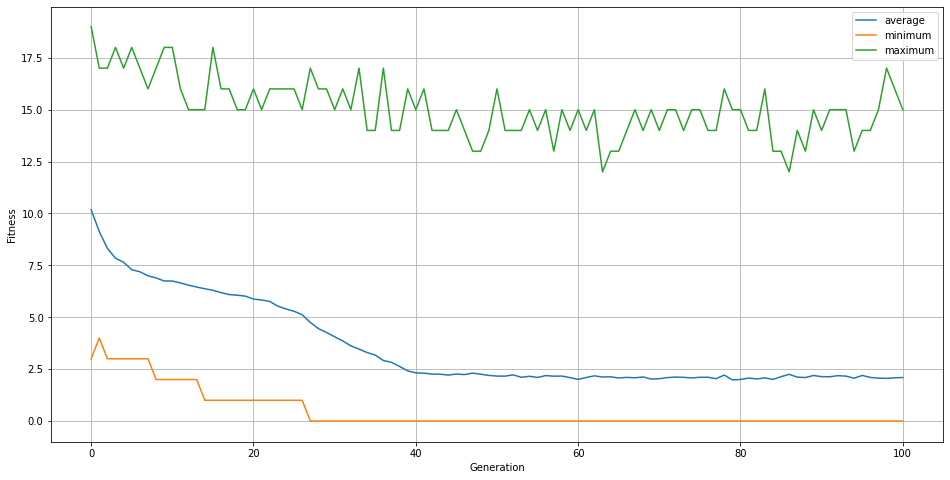

In [10]:
duration, log, fittest_individual_p8 = evolution(
    individual_generator=lambda: random.choices(range(8**2), k=8),
    fitness_evaluation=evaluate_position_indexed_fitness,
    population_size=2500,
    generations=100,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 8**2 - 1, "indpb": 1/4})
)
print(f"Computed in {duration:.3f} seconds")
plot_generations(*log.select("gen", "avg", "min", "max"))

#### Fittest Individual

In [11]:
print(f"Positions: {fittest_individual_p8}")
print(f"Duplicate queens: {len(fittest_individual_p8) - len(set(fittest_individual_p8))}")
print(f"Fitness: {abs(fittest_individual_p8.fitness.values[0])}")
display_positional_grid(fittest_individual_p8)

Positions: [33, 61, 31, 3, 8, 50, 20, 46]
Duplicate queens: 0
Fitness: 0.0


,1,2,3,4,5,6,7,8
1,,,,👑,,,,
2,👑,,,,,,,
3,,,,,👑,,,
4,,,,,,,,👑
5,,👑,,,,,,
6,,,,,,,👑,
7,,,👑,,,,,
8,,,,,,👑,,


### Evolutionary Algorithm on a 16x16 Board
In the following section, the DEAP evolutionary algorithm is executed to solve for a single solution of the $n$-queens problem for an $16 \times 16$ chessboard using a position-indexed genetic encoding.

#### Evolutionary Computation
A larger population size and more generations are simulated, since there are expontentially more states in a $16 \times 16$ chessboard.

Computed in 326.230 seconds


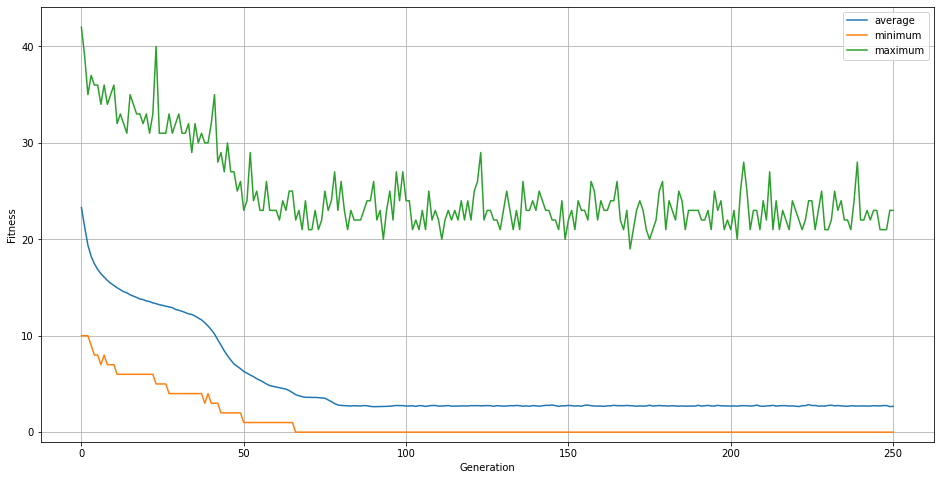

In [12]:
duration, log, fittest_individual_p16 = evolution(
    individual_generator=lambda: random.choices(range(16**2), k=16),
    fitness_evaluation=evaluate_position_indexed_fitness,
    population_size=15000,
    generations=250,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 16**2 - 1, "indpb": 1/8})
)
print(f"Computed in {duration:.3f} seconds")
plot_generations(*log.select("gen", "avg", "min", "max"))

#### Fittest Individual

In [13]:
print(f"Positions: {fittest_individual_p16}")
print(f"Duplicate queens: {len(fittest_individual_p16) - len(set(fittest_individual_p16))}")
print(f"Fitness: {abs(fittest_individual_p16.fitness.values[0])}")
display_positional_grid(fittest_individual_p16)

Positions: [53, 135, 208, 251, 126, 185, 204, 1, 40, 22, 146, 93, 106, 227, 79, 164]
Duplicate queens: 0
Fitness: 0.0


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,,👑,,,,,,,,,,,,,,
2,,,,,,,👑,,,,,,,,,
3,,,,,,,,,👑,,,,,,,
4,,,,,,👑,,,,,,,,,,
5,,,,,,,,,,,,,,,,👑
6,,,,,,,,,,,,,,👑,,
7,,,,,,,,,,,👑,,,,,
8,,,,,,,,,,,,,,,👑,
9,,,,,,,,👑,,,,,,,,
10,,,👑,,,,,,,,,,,,,


<hr style="border-top: 2px solid #444">

## III. Row-index Board Encoding
The row-indexed genetic encoding makes use of the [Pigeonhole principle](https://en.wikipedia.org/wiki/Pigeonhole_principle) so there is only a single queen per row.  Individuals are genetically encoded as an integer list of $n$ elements. Each element $p$ is in the range $p\in[0, n)$, derived from the element's column; the element's index indicates the row.

The state-space complexity is $O(n^{n})$:
- for $n = 8$: there are $8^8=16,777,216$ possible states
- for $n = 16$: there are $16^{16}=18,446,744,073,709,551,616$ possible states

### Rendering Row-indexed Board
The position-indexed board renderer is reused by mapping values from row-indexed boards to position-indexed boards.

In [14]:
def display_row_grid(individual: List[int]):
    dimension = len(individual)
    display_positional_grid([dimension * i + individual[i] for i in range(dimension)])

### Example 8x8 Row-indexed Individual

The following is an example of a randomly generated \$8 \times 8\$ individual's row-indexed genetic encoding and board representation.

In [15]:
example_individual = random.sample(range(8), 8)
print(f"Positions: {example_individual}")
display_row_grid(example_individual)

Positions: [0, 7, 3, 6, 4, 5, 1, 2]


,1,2,3,4,5,6,7,8
1,♕,,,,,,,
2,,🟥,,,,,,♕
3,,,🟥,👑,,,🟥,
4,,,,🟥,,🟥,♕,
5,,,,,♕,🟥,,
6,,,,,🟥,♕,,
7,,♕,,🟥,,,,
8,,,♕,,,,,


### Row-indexed Fitness Evaluation Function
The following method is the fitness evaluation function for row-indexed individuals. Individual fitness is defined as the number of distinct pairs of queens that are threatening each other.

Time complexity: $O(|queens|^2)$

In [16]:
def evaluate_row_indexed_fitness(individual: List[int]) -> float:
    fitness: float = 0
    for x in range(len(individual)):
        for y in range(x + 1, len(individual)):
            if individual[x] == individual[y] or abs(x - y) == abs(individual[x] - individual[y]):
                fitness += 1
    return fitness

### Evolutionary Algorithm on a 8x8 Board

In the following section, the DEAP evolutionary algorithm is executed to solve for a single solution of the $n$-queens problem for an $8 \times 8$ chessboard using a row-indexed genetic encoding.

#### Evolutionary Computation

A significantly smaller population size and generation count is simulated with the row-index board encoding, compared to the position-indexed simulation.

Computed in 1.238 seconds


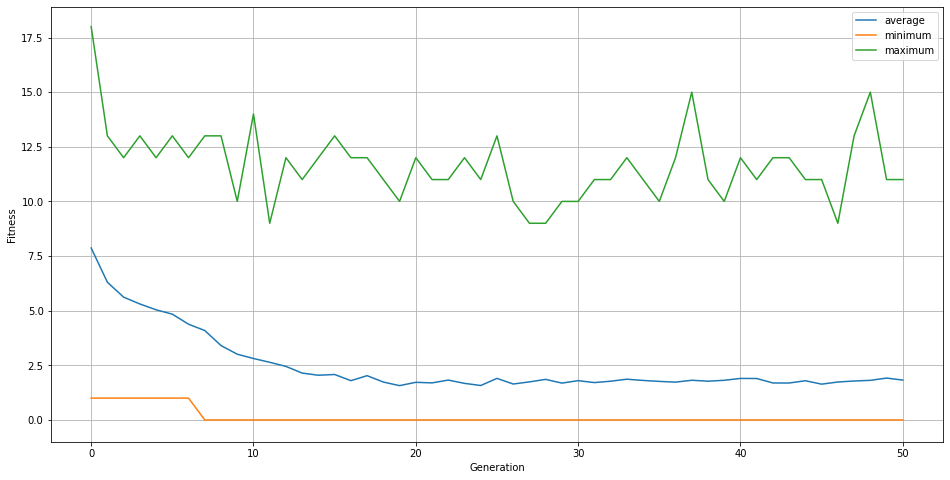

In [17]:
duration, log, fittest_individual_r8 = evolution(
    individual_generator=lambda: random.choices(range(8), k=8),
    fitness_evaluation=evaluate_row_indexed_fitness,
    population_size=500,
    generations=50,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 8 - 1, "indpb": 1/4})
)
print(f"Computed in {duration:.3f} seconds")
plot_generations(*log.select("gen", "avg", "min", "max"))

#### Fittest Individual

In [18]:
print(f"Positions: {fittest_individual_r8}")
print(f"Fitness: {abs(fittest_individual_r8.fitness.values[0])}")
display_row_grid(fittest_individual_r8)

Positions: [5, 3, 1, 7, 4, 6, 0, 2]
Fitness: 0.0


,1,2,3,4,5,6,7,8
1,,,,,,👑,,
2,,,,👑,,,,
3,,👑,,,,,,
4,,,,,,,,👑
5,,,,,👑,,,
6,,,,,,,👑,
7,👑,,,,,,,
8,,,👑,,,,,


### Evolutionary Algorithm on a 16x16 Board
In the following section, the DEAP evolutionary algorithm is executed to solve for a single solution of the $n$-queens problem for an $16 \times 16$ chessboard using a row-indexed genetic encoding.

#### Evolutionary Computation
A significantly smaller population size is simulated with the row-index board encoding, compared to the position-indexed simulation.

Computed in 107.635 seconds


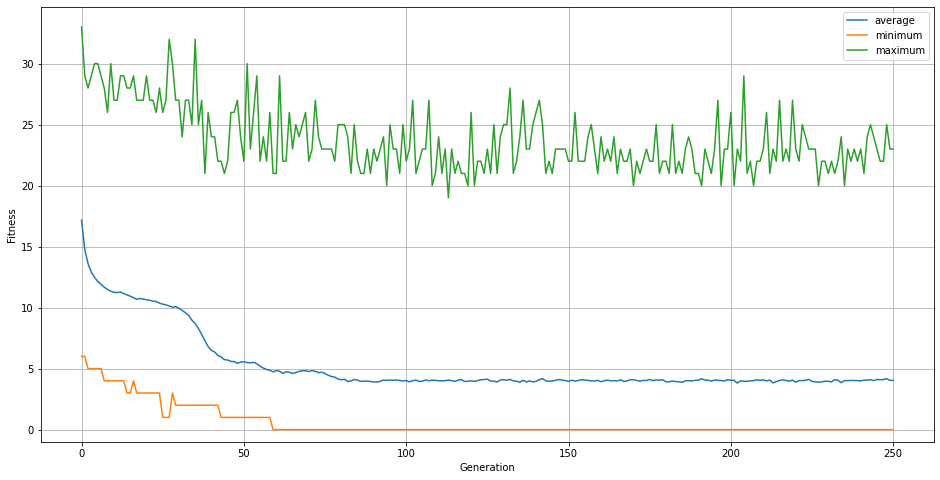

In [19]:
duration, log, fittest_individual_r16 = evolution(
    individual_generator=lambda: random.choices(range(16), k=16),
    fitness_evaluation=evaluate_row_indexed_fitness,
    population_size=5000,
    generations=250,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 16 - 1, "indpb": 1/4})
)
print(f"Computed in {duration:.3f} seconds")
plot_generations(*log.select("gen", "avg", "min", "max"))

#### Fittest Individual

In [20]:
print(f"Positions: {fittest_individual_r16}")
print(f"Fitness: {abs(fittest_individual_r16.fitness.values[0])}")
display_row_grid(fittest_individual_r16)

Positions: [15, 6, 9, 11, 8, 14, 0, 3, 1, 4, 7, 12, 10, 13, 2, 5]
Fitness: 0.0


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,,,,,,,,,,,,,,,,👑
2,,,,,,,👑,,,,,,,,,
3,,,,,,,,,,👑,,,,,,
4,,,,,,,,,,,,👑,,,,
5,,,,,,,,,👑,,,,,,,
6,,,,,,,,,,,,,,,👑,
7,👑,,,,,,,,,,,,,,,
8,,,,👑,,,,,,,,,,,,
9,,👑,,,,,,,,,,,,,,
10,,,,,👑,,,,,,,,,,,


### Evolutionary Algorithm on a 32x32 Board
In the following section, the DEAP evolutionary algorithm is executed to solve for a single solution of the $n$-queens problem for an $32 \times 32$ chessboard using a row-indexed genetic encoding.

#### Evolutionary Computation

Computed in 1269.433 seconds


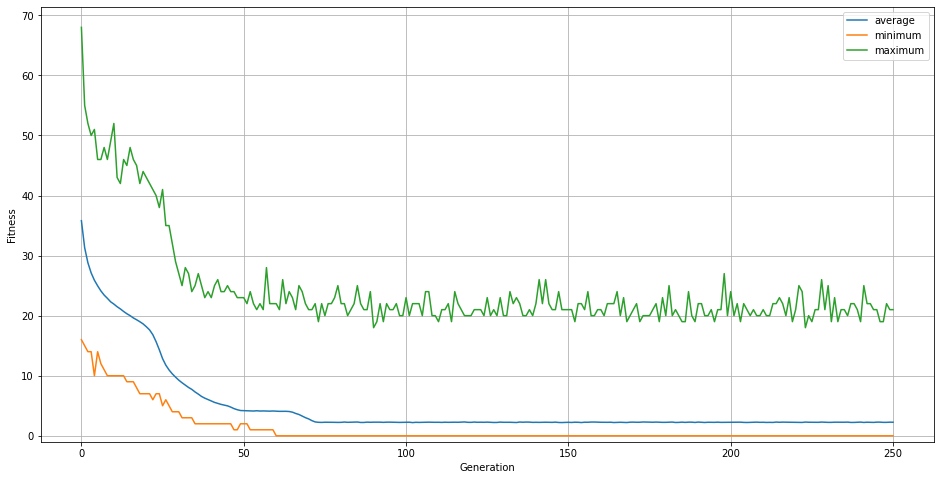

In [21]:
duration, log, fittest_individual_r32 = evolution(
    individual_generator=lambda: random.choices(range(32), k=32),
    fitness_evaluation=evaluate_row_indexed_fitness,
    population_size=25000,
    generations=250,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 32 - 1, "indpb": 1/16})
)
print(f"Computed in {duration:.3f} seconds")
plot_generations(*log.select("gen", "avg", "min", "max"))

#### Fittest Individual

In [22]:
print(f"Positions: {fittest_individual_r32}")
print(f"Fitness: {abs(fittest_individual_r32.fitness.values[0])}")
display_row_grid(fittest_individual_r32)

Positions: [28, 9, 3, 16, 22, 25, 2, 18, 31, 12, 4, 23, 29, 10, 1, 30, 0, 15, 20, 8, 26, 14, 27, 6, 24, 17, 11, 13, 5, 7, 21, 19]
Fitness: 0.0


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,👑,,,
2,,,,,,,,,,👑,,,,,,,,,,,,,,,,,,,,,,
3,,,,👑,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,,,,,,,,,,,,,,,,,👑,,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,,,,,,,,,👑,,,,,,,,,
6,,,,,,,,,,,,,,,,,,,,,,,,,,👑,,,,,,
7,,,👑,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,,,,,,,,,,,,,,,,,,,👑,,,,,,,,,,,,,
9,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,👑
10,,,,,,,,,,,,,👑,,,,,,,,,,,,,,,,,,,


### Evolutionary Algorithm on a 64x64 Board
In the following section, the DEAP evolutionary algorithm is executed to solve for a single solution of the $n$-queens problem for an $64 \times 64$ chessboard using a row-indexed genetic encoding.

#### Evolutionary Computation

Computed in 18581.660 seconds


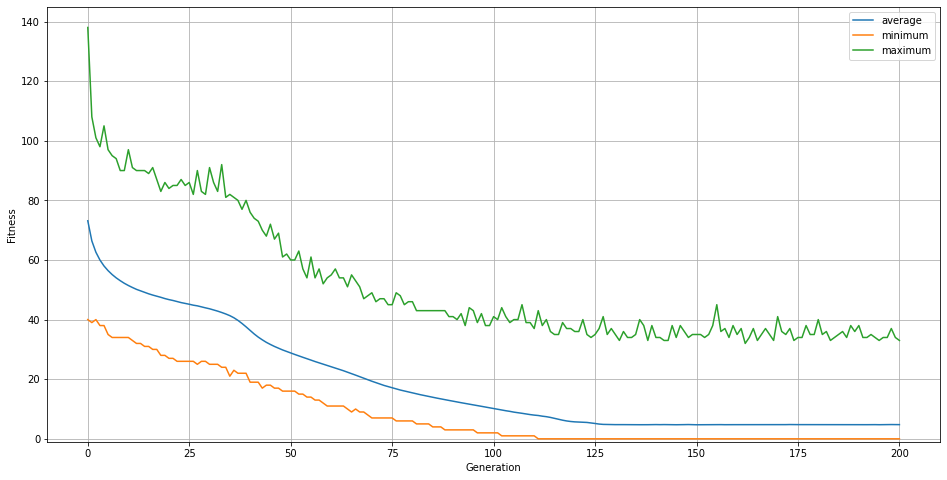

In [23]:
duration, log, fittest_individual_r64 = evolution(
    individual_generator=lambda: random.choices(range(64), k=64),
    fitness_evaluation=evaluate_row_indexed_fitness,
    population_size=150000,
    generations=200,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 64 - 1, "indpb": 1/16})
)
print(f"Computed in {duration:.3f} seconds")
plot_generations(*log.select("gen", "avg", "min", "max"))

#### Fittest Individual

In [24]:
print(f"Positions: {fittest_individual_r64}")
print(f"Fitness: {abs(fittest_individual_r64.fitness.values[0])}")

Positions: [58, 24, 16, 36, 25, 2, 7, 26, 35, 37, 32, 62, 57, 54, 21, 49, 12, 10, 34, 19, 30, 63, 60, 1, 39, 56, 8, 22, 52, 46, 48, 6, 38, 3, 20, 61, 9, 50, 17, 27, 45, 15, 23, 28, 0, 47, 5, 41, 31, 4, 53, 55, 43, 40, 44, 13, 18, 33, 42, 51, 59, 11, 29, 14]
Fitness: 0.0


<hr style="border-top: 2px solid #444">

## IV. Conclusion

The results of this notebook indicate that it is possible to solve the $n$-queens problem for moderate values of $n$ using evolutionary algorithms and genetic programming. However, finding a solution with this method is a computationally expensive process that is not on par with the performance of traditionally-designed algorithms - in some cases, several order magnitudes slower. As far as naive brute-force solutions are concerned, evolutionary algorithms are able to find solutions in less time than a backtracking depth-first search.

A few observations:
- Reducing the state space for genetic encodings can significantly reduce the population size and generation count required for finding a valid solution. As a consequence, the time to find a solution is also reduced.
- Genetic diversity, through a large enough sample size, plays the most significant role for finding a valid solution. Adjusting other parameters generally does not improve the ability to find a solution; however, extreme values of parameters will certainly prevent a solution from being found.
- A significant bottleneck is the efficiency of computing the fitness for the fitness evaluation function.
